In [112]:
import sklearn.svm as svm
import numpy as np
import pandas as pd
import os
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from lofo import LOFOImportance, plot_importance, Dataset
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 500
%matplotlib inline
working_dir='E:/Ender/data/UAV/HIPS/relative_height/'


In [107]:
def combined_df(working_dir,feature_name):
    date=os.listdir(working_dir)
    for i in range(len(date)):
        feature_path=working_dir+date[i]+'/'+feature_name
        if i==0:
            features=pd.read_csv(feature_path)
        else:
            tempp=pd.read_csv(feature_path)
            features=pd.concat([features,tempp])
    return features


In [2]:

def divide_data(date, feature_file):
    '''
    We need to divide data into 75%, 25% for each date.
    '''
    X_train_daily=[]
    y_train_daily=[]
    X_test_daily=[]
    y_test_daily=[]
    for d in range(len(date)):
        p='E:/Ender/data/UAV/HIPS/relative_height/'+date[d]+'/'+ feature_file
        print(p)
        df=pd.read_csv(p)
        headers=df.keys()
        headers=headers[1::]
        y_temp=np.array(df['LAI'])
        X_temp=np.zeros([len(y_temp),len(headers)-1])
        for i in range(len(y_temp)):
            for j in range(len(headers)-1):
                X_temp[i,j]=df[headers[j]].iloc[i]
        sc_X = StandardScaler()
        X = sc_X.fit_transform(X_temp.reshape(-1,len(headers)-1))
        ### Don't standardize y!!!!
        X_train, X_test, y_train, y_test = train_test_split(X, y_temp, test_size=0.25, random_state=0)
        X_train_daily.append(X_train)
        y_train_daily.append(y_train)
        X_test_daily.append(X_test)
        y_test_daily.append(y_test)   
    return X_train_daily, X_test_daily, y_train_daily, y_test_daily,headers

In [3]:
date=os.listdir(working_dir)
X_train_daily, X_test_daily, y_train_daily, y_test_daily,headers=divide_data(date,'features.csv')
X_train=np.array(X_train_daily).reshape((-1,8))
X_test=np.array(X_test_daily).reshape((-1,8))
y_train=np.array(y_train_daily).flatten()
y_test=np.array(y_test_daily).flatten()
print(X_test.shape)
print(X_test[0])
# print(np.min(y_train))


E:/Ender/data/UAV/HIPS/relative_height/20210730/features.csv
E:/Ender/data/UAV/HIPS/relative_height/20210804/features.csv
E:/Ender/data/UAV/HIPS/relative_height/20210808/features.csv
E:/Ender/data/UAV/HIPS/relative_height/20210816/features.csv
E:/Ender/data/UAV/HIPS/relative_height/20210822/features.csv
E:/Ender/data/UAV/HIPS/relative_height/20210828/features.csv
(138, 8)
[-0.77935589  1.46974468  1.50550315  1.18917273 -0.99185627 -1.05554677
 -0.09362998  1.42837955]


In [105]:
def grid_search(X_train, X_test, y_train, y_test):
    param_grid={'C':[0.05*i for i in range(1,30)],
                'gamma':[0.05*i for i in range(1,30)],
                'epsilon':[0.1,0.3,0.5],
                'kernel':['rbf']}
    grid=GridSearchCV(svm.SVR(),param_grid=param_grid,refit=True,verbose=3,cv=10,n_jobs=-1,return_train_score=True)
    grid.fit(X_train,y_train)
    # grid_prediction=grid.predict(X_test)
    print(grid.best_params_) 
    print(r'R**2:',grid.score(X_test,y_test))
    print(grid.best_score_)
    # print(grid.cv_results_.keys())
    return grid
grid=grid_search(X_train, X_test, y_train, y_test)

Fitting 10 folds for each of 2523 candidates, totalling 25230 fits
{'C': 0.05, 'epsilon': 0.3, 'gamma': 0.1, 'kernel': 'rbf'}
R**2: 0.33625161642724366
0.04703020327959031


In [83]:

training=pd.DataFrame(grid.cv_results_)
training.to_csv('E:/Ender/LAI/result/training.csv')

0.6194718702681234
0.1096698181106578
0.592149318497516
0.11495308795185244


In [123]:
features=combined_df(working_dir,'features.csv')
headers=list(headers)
try:
    headers.remove('LAI')
except: pass
headers[-1]
print(X_train.shape)

(402, 8)


In [84]:
reg=svm.SVR()
reg.fit(X_train,y_train)
# print(reg.score(X_test,y_test))

SVR()

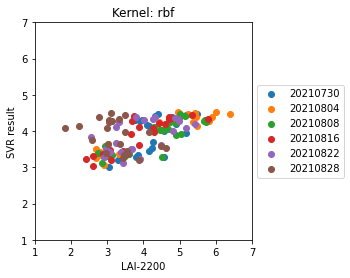

In [106]:
def scatter_plot(model):
    for d in range(len(date)):
        y_SVR=model.predict(X_test_daily[d])
        plt.scatter(y_test_daily[d],y_SVR,label=date[d])
    # y_SVR=grid.predict(X_test)
    # y_SVR = sc_y.inverse_transform((grid.predict(X_test)))
    # plt.scatter(y_test,y_SVR)
    plt.xlabel('LAI-2200')
    plt.ylabel('SVR result')
    plt.xlim((1,7))
    plt.ylim((1,7))
    plt.title('Kernel: rbf')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
scatter_plot(grid)

In [5]:
date=os.listdir(working_dir)
date

['20210730', '20210804', '20210808', '20210816', '20210822', '20210828']

In [69]:
def daily_result(d,model):
    p='E:/Ender/data/UAV/HIPS/relative_height/20210730/features.csv'
    p=p.replace('20210730',d)
    df=pd.read_csv(p)
    headers=df.keys()
    headers=headers[1::]
    y=df['LAI']
    X1=np.zeros([len(y),len(headers)-1])
    for i in range(len(y)):
        for j in range(len(headers)-1):
            X1[i,j]=df[headers[j]].iloc[i]
    return model.score(X1,y)

In [7]:
df=dict()
df['date']=[]
df['R2']=[]
df['GDD']=[1836,1958,2061,2284,2445,2621]
for d in range(len(date)):
    df['date'].append(date[d])
    df['R2'].append(grid.score(X_test_daily[d],y_test_daily[d]))
df=pd.DataFrame(df)
df

,date,R2,GDD
0,20210730,0.081994,1836
1,20210804,0.494555,1958
2,20210808,0.365024,2061
3,20210816,0.604555,2284
4,20210822,0.321576,2445
5,20210828,-1.831913,2621


In [8]:
import plotly.express as px
fig = px.bar(df, x='GDD', y='R2',width=500)
fig.update_layout(yaxis=dict(title='R<sup>2</sup>'),
    xaxis = dict(
        tickmode = 'array',
        tickvals = df['GDD']))
fig.show()

In [72]:
def mean_feature(working_dir,feature_name):
    df=dict()
    date=os.listdir(working_dir)
    for i in range(len(date)):
        feature_path=working_dir+date[i]+'/'+feature_name
        features=pd.read_csv(feature_path)
        if i==0:
            headers=features.keys()
            headers=headers[1::]
            for j in headers:
                df[j]=[np.mean(features[j])]
        else:
            tempp=pd.read_csv(feature_path)
            for j in headers:
                df[j].append(np.mean(tempp[j]))
            # features=pd.concat([features,tempp])
    return df
f=mean_feature(working_dir,'features.csv')
f=pd.DataFrame(f)
f.head(6)

,LPI,mean_height,75%_height,std,skewness,VCI_HB_const,CAP,vol,LAI
0,0.051900,1.568970,1.992444,0.544710,-0.852919,0.863270,14.598403,14.030609,4.133433
1,0.042977,1.541900,1.988889,0.571487,-0.855232,0.870154,14.604360,13.868691,4.084644
2,0.073538,1.668147,2.040333,0.488048,-0.985942,0.806242,13.452749,10.328154,4.012089
3,0.009226,1.628341,2.068528,0.586728,-1.143042,0.807774,11.811059,2.752205,3.602356
4,0.014013,1.567557,2.043583,0.629283,-1.048306,0.818632,11.128142,2.537685,3.626533
5,0.008232,1.643123,2.107806,0.616880,-1.095610,0.798266,10.343491,2.135494,3.310278


In [45]:
import plotly.graph_objects as go
df=dict()
df['date']=[]
df['R2']=[]
df['GDD']=[1836,1958,2061,2284,2445,2621]
for d in range(len(date)):
    df['date'].append(date[d])
    df['R2'].append(grid.score(X_test_daily[d],y_test_daily[d]))

df=pd.DataFrame(df)
df_2020=dict()
df_2020['GDD']=[961,1138,1275,1436,1547,1635,1862]
df_2020['R2']= [0.28,0.38,0.58,0.57,0.59,0.48,0.55]

df_2020HIPS=dict()
df_2020HIPS['GDD']=[1275,1381,2258]
df_2020HIPS['R2']=[0.77,0.78,0.8]
xtick=np.hstack([df_2020['GDD'],df['GDD'],df_2020HIPS['GDD']])
# xtick=xtick[xtick!=1836]
print(xtick)
fig=go.Figure()
fig.add_trace(go.Bar(x=df['GDD'],y=df['R2'],marker_color='red',name='2021: HIPS'))
fig.add_trace(go.Bar(x=df_2020['GDD'],y=df_2020['R2'],marker_color='blue',name='2020: Sbdiv TC Cal'))
fig.add_trace(go.Bar(x=df_2020HIPS['GDD'],y=df_2020HIPS['R2'],marker_color='green',name='2020: HIPS'))

fig.update_layout(width=800,yaxis=dict(title='R<sup>2</sup>'),
    xaxis = dict(
        title='GDD',
        tickmode = 'array',
        tickvals = xtick))
fig.show()

[ 961 1138 1275 1436 1547 1635 1862 1836 1958 2061 2284 2445 2621 1275
 1381 2258]


In [30]:
# SVR version2: Include canopy cover from TJ's code
date=os.listdir(working_dir)
X_train_daily2, X_test_daily2, y_train_daily2, y_test_daily2,headers2=divide_data(date,'features3.csv')
X_train2=np.array(X_train_daily2).reshape((-1,len(headers2)-1))
X_test2=np.array(X_test_daily2).reshape((-1,len(headers2)-1))
y_train2=np.array(y_train_daily2).flatten()
y_test2=np.array(y_test_daily2).flatten()
print(headers2)
print(X_test2.shape)
# print(X_test2[0])

E:/Ender/data/UAV/HIPS/relative_height/20210730/features3.csv
E:/Ender/data/UAV/HIPS/relative_height/20210804/features3.csv
E:/Ender/data/UAV/HIPS/relative_height/20210808/features3.csv
E:/Ender/data/UAV/HIPS/relative_height/20210816/features3.csv
E:/Ender/data/UAV/HIPS/relative_height/20210822/features3.csv
E:/Ender/data/UAV/HIPS/relative_height/20210828/features3.csv
Index(['LPI', 'mean_height', '75%_height', 'std', 'skewness', 'VCI_HB_const',
       'CAP', 'vol', 'LII5%', 'LII10%', 'LII20%', 'LII30%', 'LII40%', 'LII50%',
       'LII75%', 'LAI'],
      dtype='object')
(138, 15)


In [31]:
grid2=grid_search(X_train2, X_test2, y_train2, y_test2)


Fitting 10 folds for each of 7500 candidates, totalling 75000 fits
{'C': 0.16, 'epsilon': 0.5, 'gamma': 0.2, 'kernel': 'rbf'}
R**2: 0.4212189472760317


E:\Ender\code\envv\ggdal\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning:

One or more of the test scores are non-finite: [        nan         nan         nan ... -0.22095975 -0.22154281
 -0.22208535]



In [56]:
reg.fit(X_train2,y_train2)
reg.score(X_test2,y_test2)

0.44679464677307246

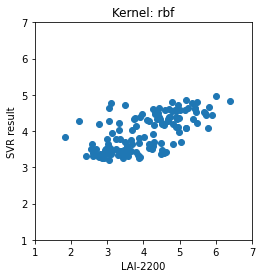

In [32]:
y_SVR2=grid2.predict(X_test2)
plt.scatter(y_test2,y_SVR2)
plt.xlabel('LAI-2200')
plt.ylabel('SVR result')
plt.xlim((1,7))
plt.ylim((1,7))
plt.title('Kernel: rbf')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [34]:
dfv2=dict()
dfv2['date']=[]
dfv2['R2']=[]
dfv2['GDD']=[1836,1958,2061,2284,2445,2621]
for d in range(len(date)):
    dfv2['date'].append(date[d])
    dfv2['R2'].append(grid2.score(X_test_daily2[d],y_test_daily2[d]))
dfv2=pd.DataFrame(dfv2)
dfv2

,date,R2,GDD
0,20210730,0.214077,1836
1,20210804,0.606826,1958
2,20210808,0.507735,2061
3,20210816,0.600460,2284
4,20210822,0.390126,2445
5,20210828,-1.882163,2621


In [39]:
fig=go.Figure()
fig.add_trace(go.Bar(x=dfv2['GDD'],y=dfv2['R2'],marker_color='red',name='2021'))
fig.add_trace(go.Bar(x=df_2020['GDD'],y=df_2020['R2'],marker_color='blue',name='2020: Sbdiv TC Cal'))
fig.add_trace(go.Bar(x=df_2020HIPS['GDD'],y=df_2020HIPS['R2'],marker_color='green',name='2020: HIPS'))
xtick=np.hstack([df_2020['GDD'],df['GDD'],df_2020HIPS['GDD']])
xtick=xtick[xtick!=1836]
fig.update_layout(width=800,yaxis=dict(title='R<sup>2</sup>'),
    xaxis = dict(
        title='GDD',
        tickmode = 'array',
        tickvals = xtick))
fig.show()

In [14]:
# SVR version3: Exclude height related features

def divide_datav3(date, feature_file):
    '''
    We need to divide data into 75%, 25% for each date.
    '''
    X_train_daily=[]
    y_train_daily=[]
    X_test_daily=[]
    y_test_daily=[]
    for d in range(len(date)):
        p='E:/Ender/data/UAV/HIPS/relative_height/'+date[d]+'/'+ feature_file
        print(p)
        df=pd.read_csv(p)
        headers=['LPI','skewness','VCI_HB_const','CAP','vol','LII5%','LII10%','LII20%','LII30%','LII40%','LII50%','LII75%']
        y_temp=np.array(df['LAI'])
        X_temp=np.zeros([len(y_temp),len(headers)])
        for i in range(len(y_temp)):
            for j in range(len(headers)):
                X_temp[i,j]=df[headers[j]].iloc[i]
        sc_X = StandardScaler()
        X = sc_X.fit_transform(X_temp.reshape(-1,len(headers)))
        ### Don't standardize y!!!!
        X_train, X_test, y_train, y_test = train_test_split(X, y_temp, test_size=0.25, random_state=0)
        X_train_daily.append(X_train)
        y_train_daily.append(y_train)
        X_test_daily.append(X_test)
        y_test_daily.append(y_test) 
    return X_train_daily, X_test_daily, y_train_daily, y_test_daily,headers

In [15]:
X_train_daily3, X_test_daily3, y_train_daily3, y_test_daily3,headers3=divide_datav3(date,'features3.csv')
print(headers3)
X_train3=np.array(X_train_daily3).reshape((-1,len(headers3)))
X_test3=np.array(X_test_daily3).reshape((-1,len(headers3)))
y_train3=np.array(y_train_daily3).flatten()
y_test3=np.array(y_test_daily3).flatten()
print(X_test3.shape)


E:/Ender/data/UAV/HIPS/relative_height/20210730/features3.csv
E:/Ender/data/UAV/HIPS/relative_height/20210804/features3.csv
E:/Ender/data/UAV/HIPS/relative_height/20210808/features3.csv
E:/Ender/data/UAV/HIPS/relative_height/20210816/features3.csv
E:/Ender/data/UAV/HIPS/relative_height/20210822/features3.csv
E:/Ender/data/UAV/HIPS/relative_height/20210828/features3.csv
['LPI', 'skewness', 'VCI_HB_const', 'CAP', 'vol', 'LII5%', 'LII10%', 'LII20%', 'LII30%', 'LII40%', 'LII50%', 'LII75%']
(138, 12)


In [16]:
grid3=grid_search(X_train3, X_test3, y_train3, y_test3)

Fitting 10 folds for each of 7500 candidates, totalling 75000 fits
{'C': 0.08, 'epsilon': 0.3, 'gamma': 0.2, 'kernel': 'rbf'}
R**2: 0.384110926148049


E:\Ender\code\envv\ggdal\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning:

One or more of the test scores are non-finite: [        nan         nan         nan ... -0.20979749 -0.21095751
 -0.21204146]



In [18]:
dfv3=dict()
dfv3['date']=[]
dfv3['R2']=[]
dfv3['GDD']=[1836,1958,2061,2284,2445,2621]
for d in range(len(date)):
    dfv3['date'].append(date[d])
    dfv3['R2'].append(grid3.score(X_test_daily3[d],y_test_daily3[d]))
dfv3=pd.DataFrame(dfv3)
dfv3

,date,R2,GDD
0,20210730,0.014757,1836
1,20210804,0.560584,1958
2,20210808,0.459348,2061
3,20210816,0.673304,2284
4,20210822,0.336154,2445
5,20210828,-1.992927,2621


In [20]:
fig=go.Figure()
fig.add_trace(go.Bar(x=dfv3['GDD'],y=dfv3['R2'],marker_color='red',name='2021'))
fig.add_trace(go.Bar(x=df_2020['GDD'],y=df_2020['R2'],marker_color='blue',name='2020'))
fig.update_layout(width=800,yaxis=dict(title='R<sup>2</sup>'),
    xaxis = dict(
        title='GDD',
        tickmode = 'array',
        tickvals = xtick))
fig.show()

In [23]:
fig=go.Figure()
fig.add_trace(go.Bar(x=df['GDD'],y=df['R2'],marker_color='red',name='2021_v1'))
fig.add_trace(go.Bar(x=dfv2['GDD'],y=dfv2['R2'],marker_color='orange',name='2021_v2'))
fig.add_trace(go.Bar(x=dfv3['GDD'],y=dfv3['R2'],marker_color='green',name='2021_v3'))
# fig.add_trace(go.Bar(x=df_2020['GDD'],y=df_2020['R2'],marker_color='blue',name='2020'))
fig.update_layout(width=800,yaxis=dict(title='R<sup>2</sup>'),
    xaxis = dict(
        title='GDD',
        tickmode = 'array',
        tickvals = xtick))
fig.show()